### Importación de las librerías a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Cargo el dataset desde un archivo CSV y lo convierto en un dataframe

In [2]:


df_bank = pd.read_csv('bank_dataset.CSV', header=0, delimiter= ",")

Elimino las variables/columnas que no necesitaré para el proyecto. Este paso lo he decidido desde la tarea anterior (EDA) para tener un dataframe más ligero.

In [3]:
df_bank = df_bank.drop(columns=['contact', 'default', 'day', 'month', 'duration','campaign', 'pdays','poutcome', 'previous'])

Muestro las primeras filas para ver que se han cargado correctamente.

In [4]:
df_bank.head()

,age,job,marital,education,balance,housing,loan,deposit
0,59.0,admin.,married,secondary,2343,yes,no,yes
1,56.0,admin.,married,secondary,45,no,no,yes
2,41.0,technician,married,secondary,1270,yes,no,yes
3,55.0,services,married,secondary,2476,yes,no,yes
4,54.0,admin.,married,tertiary,184,no,no,yes


Compruebo la existencia de valores nulos, existen dentro de age(10), marital (5), education(7). 

In [5]:
df_bank.isnull().sum()

age          10
job           0
marital       5
education     7
balance       0
housing       0
loan          0
deposit       0
dtype: int64

En el caso de age utilizaré la media de `marital` para completar los valores faltantes

In [6]:
avg_ages = df_bank.groupby("marital")["age"].mean().round()

for status, avg_age in avg_ages.items():
    df_bank.loc[(df_bank["marital"] == status) & (df_bank["age"].isna()), "age"] = avg_age

En la variable `age` observo también que los valores dentro de esta presentan números decimales y es del tipo (float); no tiene sentido que se mantenga así y cambio el tipo a (int)

In [7]:
df_bank['age'] = df_bank['age'].astype('int')

En el caso de la variable `marital` utilizo la moda para imputar los valores nulos

In [8]:
moda_marital = df_bank.groupby(['job', 'age'])['marital'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df_bank['marital'] = df_bank['marital'].fillna(moda_marital)

Para la variable `education` utilizo la moda para imputar los valores nulos

In [9]:
moda_education = df_bank.groupby(['job', 'age'])['education'].transform(lambda x: x.mode()[0] if not x.isnull().all() else None)
df_bank['education'] = df_bank['education'].fillna(moda_education)

Compruebo que se hayan eliminado los valores nulos

In [10]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
loan         0
deposit      0
dtype: int64

Observo que en la variable de `job` hay varias categorías, enlisto la cantidad de clientes que hay por cada una, por lo que probaré crear subgrupos para reducir la cantidad de categorías de esta variable, buscando evitar tener muchas columnas cuando trabaje con la codificación de esta variable y su posterior uso al trabajar con el algoritmo (K-MEans Clustering).

In [11]:
cantidades_education = df_bank.groupby('job').size()
print(cantidades_education)

job
admin.           1334
blue-collar      1944
entrepreneur      328
housemaid         274
management       2566
retired           778
self-employed     405
services          923
student           360
technician       1823
unemployed        357
unknown            70
dtype: int64


Decido crear 4 categorías para probar reducir la dimensión de esta variable previo a la codificación

In [12]:
job_mapeo = {
    "admin.": "profesional",
    "technician": "profesional",
    "management": "profesional",
    "entrepreneur": "profesional",
    "self-employed": "profesional",
    "blue-collar": "manual",
    "services": "manual",
    "housemaid": "manual",
    "unemployed": "otro",
    "student": "otro",
    "unknown": "otro"
}

df_bank['job'] = df_bank['job'].replace(job_mapeo)

print(df_bank['job'].value_counts())

job
profesional    6456
manual         3141
otro            787
retired         778
Name: count, dtype: int64


En la tarea previa de EDA vi que existían una cantidad importante de outliers, a los cuales contemplo pasar por la técnica de winsorización en lugar de eliminarlos, no modifico el dataframe original y creo una copia a la que nombro `df_bank_w` para conservar los datos de origen.

In [13]:
df_bank_w = df_bank.copy()

df_bank_w['age'] = winsorize(df_bank['age'], limits= [0.05, 0.05], inplace= True)

df_bank_w['balance'] = winsorize(df_bank['balance'], limits= [0.05, 0.05], inplace= True)

Para personalizar el dataframe decido traducir al español los elementos dentro de este y así hacerlo más comprensible a las personas que lo puedan necesitar

In [14]:
df_bank_w["marital"] = np.where(df_bank_w["marital"] == "married", "casado",
                                np.where(df_bank_w["marital"] == "single", "soltero",
                                         "divorciado"))

df_bank_w["education"] = np.where(df_bank_w["education"] == "primary", "primaria",
                                np.where(df_bank_w["education"] == "secondary", "media",
                                         "superior"))

df_bank_w["housing"] = np.where(df_bank_w["housing"] == "no", "no", "sí")

df_bank_w["loan"] = np.where(df_bank_w["loan"] == "no", "no", "sí")

df_bank_w["deposit"] = np.where(df_bank_w["deposit"] == "no", "no", "sí")

df_bank_w["job"] = np.where(df_bank_w["job"] == "retired", "retirado", df_bank_w['job'])

# Renombro las columnas

df_bank_w = df_bank_w.rename(columns={
    'age': 'edad',
    'job': 'trabajo',
    'marital': 'estado_civil',
    'education': 'educacion',
    'balance': 'saldo',
    'housing': 'hipoteca',
    'loan': 'prestamos',
    'deposit': 'deposito'
    
})

df_bank_w.head()

,edad,trabajo,estado_civil,educacion,saldo,hipoteca,prestamos,deposito
0,59,profesional,casado,media,2343,sí,no,sí
1,56,profesional,casado,media,45,no,no,sí
2,41,profesional,casado,media,1270,sí,no,sí
3,55,manual,casado,media,2476,sí,no,sí
4,54,profesional,casado,superior,184,no,no,sí


Compruebo que no haya valores nulos después del paso anterior

In [15]:
df_bank_w.isnull().sum()

edad            0
trabajo         0
estado_civil    0
educacion       0
saldo           0
hipoteca        0
prestamos       0
deposito        0
dtype: int64

Codifico las variables:  `educación` para definir su caracter ordinal y las que tienen caracter binario `hipoteca`, `prestamos` y `deposito` (de si/no a 1/0)

In [16]:
educacion_numerica = {'primaria' : 1,
                     'media' : 2,
                     'superior' : 3}

   
df_bank_w['educacion'] = df_bank_w['educacion'].map(educacion_numerica).astype(int)

df_bank_w["hipoteca"] = df_bank_w["hipoteca"].map({"sí": 1, "no": 0})
df_bank_w["prestamos"] = df_bank_w["prestamos"].map({"sí": 1, "no": 0})
df_bank_w["deposito"] = df_bank_w["deposito"].map({"sí": 1, "no": 0})



Compruebo que no hayan valores nulos después de este proceso

In [17]:
df_bank_w.isnull().sum()

edad            0
trabajo         0
estado_civil    0
educacion       0
saldo           0
hipoteca        0
prestamos       0
deposito        0
dtype: int64

Utilizaré Label Encoder para codificar las variables categóricas y así puedan ser tratadas con mayor eficiencia en el modelo de ML que he elegido.

In [18]:
categorical_features = ["trabajo", "estado_civil"]

label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    
    df_bank_w[feature + "_encoded"] = label_encoders[feature].fit_transform(df_bank_w[feature])

df_bank_w = df_bank_w.drop(columns=categorical_features, axis=1)

df_bank_w.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,trabajo_encoded,estado_civil_encoded
0,59,2,2343,1,0,1,2,0
1,56,2,45,0,0,1,2,0
2,41,2,1270,1,0,1,2,0
3,55,2,2476,1,0,1,0,0
4,54,3,184,0,0,1,2,0


Realizo la separación de datos de Entrenamiento/Prueba. Los valores resultantes mostrarán la cantidad de filas y columnas que contiene cada uno.

Decido probar con una proporción 70% - 30 % para cada uno, quiero probar si es una proporción adecuada

In [19]:
from sklearn.model_selection import train_test_split

# División en entrenamiento y prueba
X_train, X_test = train_test_split(df_bank_w, test_size=0.30, random_state=0)


print("Conjunto de entrenamiento:\n", X_train.shape)
print("Conjunto de prueba:\n", X_test.shape)

Conjunto de entrenamiento:
 (7813, 8)
Conjunto de prueba:
 (3349, 8)


Estandarización de las Variables Numéricas `edad` y `saldo` con el objetivo de:

- Obtener una covergencia más rápida en el algoritmo.
- Dar un peso similar a las características para evitar que las de mayor rango tengan una influencia desproporcionada en el modelo.
- En K-Means la distancia es importante, si las características tienen escalas diferentes, las distancias se pueden ver distorsionadas y pueden afectar al rendimientod del modelo

In [20]:
# Selecciono solo las columnas a estandarizar
scale_variable = ['edad', 'saldo']

# Creo el escalador 
scaler = StandardScaler()

# Ajusto el escalador y aplico la estandarización a los datos de entrenamiento
X_train[scale_variable] = scaler.fit_transform(X_train[scale_variable])

# Aplico la estandarizacion a los datos de prueba
X_test[scale_variable] = scaler.transform(X_test[scale_variable])

# Muestro la cabecera del conjunto de entrenamiento
X_train.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,trabajo_encoded,estado_civil_encoded
2265,1.342796,2,0.244250,0,0,1,2,0
1525,-0.176727,3,-0.791871,1,1,1,2,0
1837,0.962915,2,1.066750,0,0,1,2,0
9423,-0.271698,1,-0.791871,1,0,0,0,2
8111,-0.461638,2,-0.634974,1,0,0,0,0


In [21]:
# Muestro la cabecera del conjunto de prueba
X_test.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,trabajo_encoded,estado_civil_encoded
9058,0.013213,3,-0.705578,1,0,0,0,0
3279,1.437766,2,0.410801,0,1,1,2,0
6502,-1.031459,2,-0.610837,0,1,0,0,2
9327,-0.651578,3,0.083732,1,0,0,2,2
9965,-1.126429,2,-0.766526,1,0,0,2,2


Aplico el Método del Codo con el fin de determinar la cantidad ideal de clusters para ejecutar el algoritmo

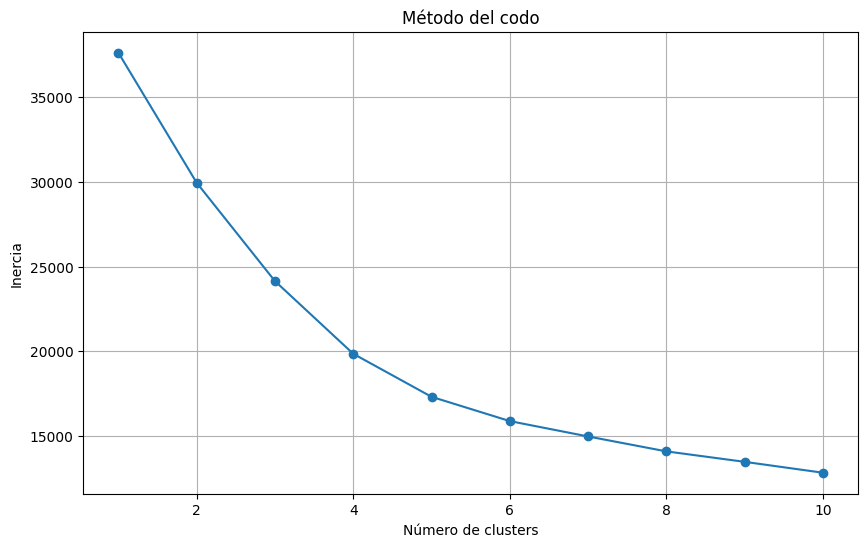

In [22]:
inertia = []

for k in range(1,11):

    kmeans = KMeans(n_clusters = k, 
                    init = "k-means++", 
                    max_iter = 300,
                    n_init = 10,
                    random_state = 42)

    kmeans.fit(X_train)
    
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))

plt.plot(range(1,11), inertia, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

Utilizo además el índice de Calinski-Harabasz para obtener una segunda determinación del número óptimo de clusters

In [23]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score


# Lista para almacenar los valores del índice de Calinski-Harabasz
calinski_scores = []

# Rango de número de clusters a evaluar
for num_clusters in range(2, 11):
    # Crear el modelo KMeans
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    
    # Ajustar el modelo a los datos
    kmeans.fit(X_train)
    
    # Obtener las etiquetas de los clusters
    labels = kmeans.labels_
    
    # Calcular el índice de Calinski-Harabasz
    score = calinski_harabasz_score(X_train, labels)
    calinski_scores.append(score)

# Encontrar el número de clusters que maximiza el índice
best_num_clusters = np.argmax(calinski_scores) + 2  # Sumamos 2 porque el rango empieza en 2

print("El número óptimo de clusters según el criterio de Calinski-Harabasz es:", best_num_clusters)

El número óptimo de clusters según el criterio de Calinski-Harabasz es: 4


Después de utilizar los dos métodos decido ejecutar el algoritmo de K-Means Clustering con 4 clusters

In [24]:
kmeans = KMeans(n_clusters = 4, 
                init="k-means++", 
                max_iter = 300, 
                n_init = 10, 
                random_state = 42)
           
X_train['cluster'] = kmeans.fit_predict(X_train)

Ejecuto Silhouette Score para evaluar la formación de los grupos.

In [25]:
score = silhouette_score(X_train, X_train['cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.355394996008274


Un resultado de 0.35 puede interpretarse que los grupos han quedado razonablemente bien definidos pero que puede haber cierta sobreposición entre ellos.

No parece una agrupación perfecta, pero es un resultado aceptable, realizaré visualizaciones para comprobarlo.

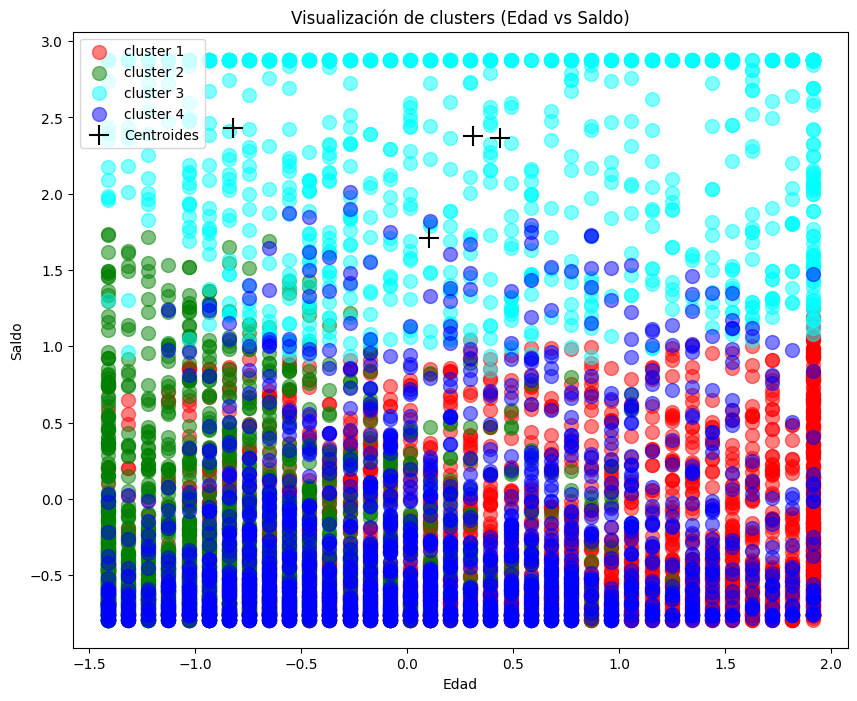

In [26]:
plt.figure(figsize=(10, 8))

colors = ['red', 'green', 'cyan', 'blue']

for i in range(4):
    plt.scatter(X_train.loc[X_train['cluster'] == i, 'edad'], 
                X_train.loc[X_train['cluster'] == i, 'saldo'], 
                s = 100, c = colors[i], label = f'cluster {i + 1}', alpha=0.5)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s = 200, c = 'black', marker='+', label='Centroides')

plt.title('Visualización de clusters (Edad vs Saldo)')
plt.xlabel('Edad')
plt.ylabel('Saldo')
plt.legend()
plt.show()

En este gráfico puede notarse la sobreposición de los grupos, realizaré otra visualización para ver los grupos por separado.

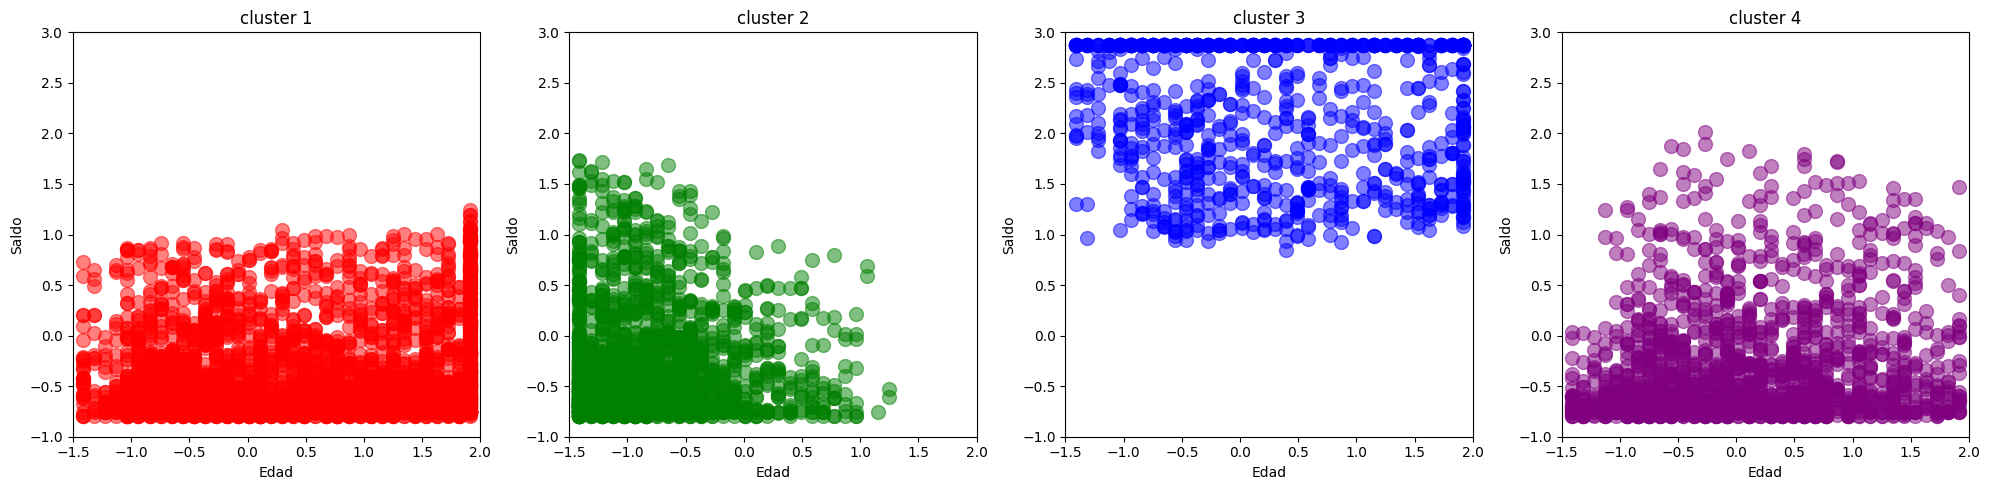

In [27]:
import matplotlib.pyplot as plt

# Creo una figura con subplots (1 fila, 5 columnas para 4 clusters)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Colores para cada cluster
colors = ['red', 'green', 'blue', 'purple']

# Creo un scatter plot para cada cluster en un subplot
for i in range(4):
    axs[i].scatter(X_train.loc[X_train["cluster"] == i, "edad"], 
                   X_train.loc[X_train["cluster"] == i, "saldo"], 
                   c=colors[i], s=100, alpha=0.5)
    axs[i].set_title(f'cluster {i + 1}')  # Título del subplot
    axs[i].set_xlabel('Edad')             # Etiqueta eje X
    axs[i].set_ylabel('Saldo')            # Etiqueta eje Y
    axs[i].set_xlim([-1.5, 2])            # Ajustar límites si es necesario
    axs[i].set_ylim([-1, 3])

plt.tight_layout()

plt.show()


Ahora pueden apreciarse los grupos, parece haber un parecido entre los clusters 1 y 4, pero para poder tener una visión más clara y entender las agrupaciones revertiré las codificaciones para visualizarlos con los valores originales, pero haciendo una copia con el fin de no comprometer los resultados obtenidos.

Realizaré tres visualizaciones para observar las distribuciones entre los clusters:

- Distribución de Observaciones por cluster
- Distribución de los elementos dentro de cada cluster teniendo en cuenta la edad y el saldo en la cuenta bancaria mediante subplots.
- Distribución mediante boxplots de `balance` y `edad`
- Distribución por categorías del conjunto.

Una vez ilustradas las agrupaciones presentaré un resumen de la interpretación de los datos visualizados.


In [28]:

X_train_nuevo = X_train.copy()

# Revertir el label encoding para las variables categóricas
for feature in categorical_features:
    X_train_nuevo[feature] = label_encoders[feature].inverse_transform(X_train[feature + "_encoded"])

# Eliminar las columnas codificadas si ya no son necesarias
X_train_nuevo = X_train_nuevo.drop(columns=[f"{feature}_encoded" for feature in categorical_features], axis=1)

# Crear copias de las variables estandarizadas 
X_train_nuevo['edad_original'] = df_bank_w['edad']
X_train_nuevo['saldo_original'] = df_bank_w['saldo']


# Crear diccionario inverso
educacion_numerica_inverso = {v: k for k, v in educacion_numerica.items()}

# Revertir el mapeo
X_train_nuevo['educacion'] = X_train['educacion'].map(educacion_numerica_inverso)
X_train_nuevo["hipoteca"] = X_train["hipoteca"].map({1: "sí", 0: "no"})
X_train_nuevo["prestamos"] = X_train["prestamos"].map({1: "sí", 0: "no"})
X_train_nuevo["deposito"] = X_train["deposito"].map({1: "sí", 0: "no"})


X_train_nuevo.head()

,edad,educacion,saldo,hipoteca,prestamos,deposito,cluster,trabajo,estado_civil,edad_original,saldo_original
2265,1.342796,media,0.244250,no,no,sí,0,profesional,casado,55,1662
1525,-0.176727,superior,-0.791871,sí,sí,sí,0,profesional,casado,39,-55
1837,0.962915,media,1.066750,no,no,sí,2,profesional,casado,51,3025
9423,-0.271698,primaria,-0.791871,sí,no,no,3,manual,soltero,38,-55
8111,-0.461638,media,-0.634974,sí,no,no,3,manual,casado,36,205


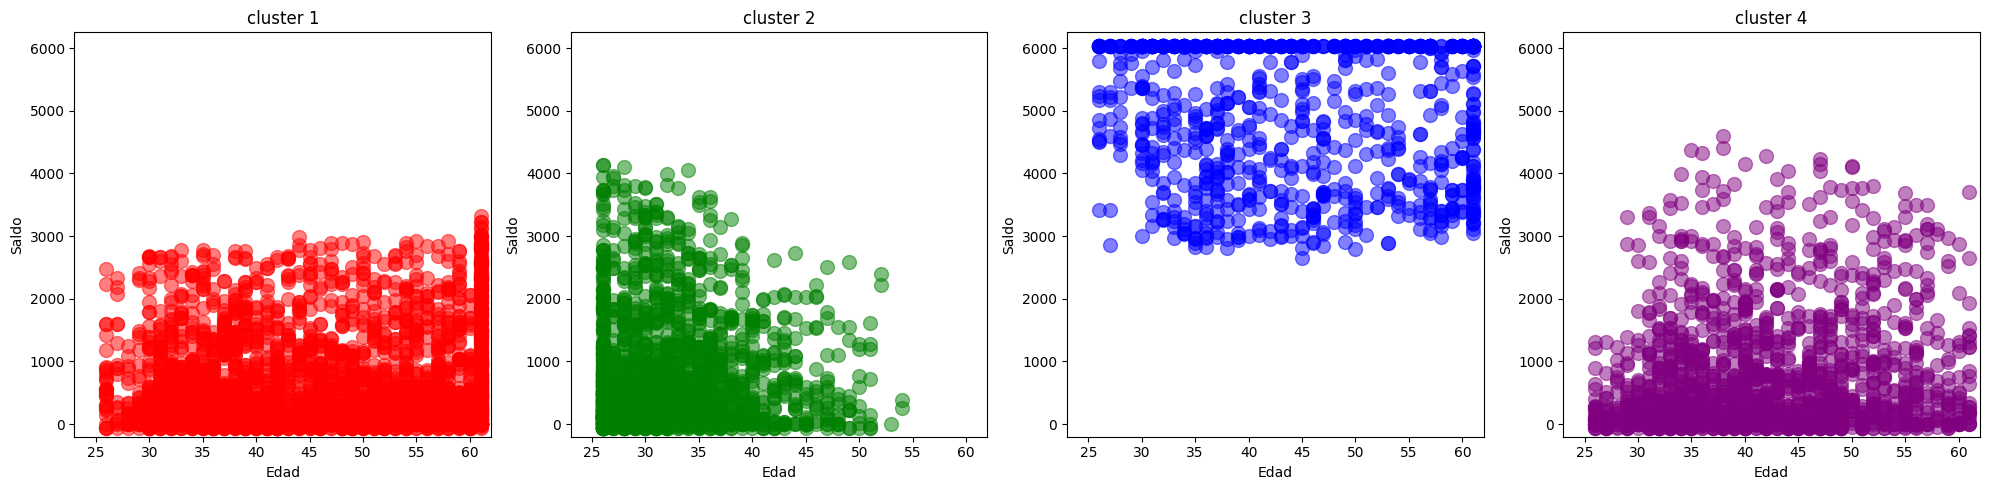

In [29]:
import matplotlib.pyplot as plt

# Crear una figura con subplots (1 fila, 5 columnas para 5 clusters)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Colores para cada cluster
colors = ['red', 'green', 'blue', 'purple', 'blue']

# Crear un scatter plot para cada cluster en un subplot
for i in range(4):
    axs[i].scatter(X_train_nuevo.loc[X_train_nuevo["cluster"] == i, "edad_original"], 
                   X_train_nuevo.loc[X_train_nuevo["cluster"] == i, "saldo_original"], 
                   c=colors[i], s=100, alpha=0.5)
    axs[i].set_title(f'cluster {i + 1}')  # Título del subplot
    axs[i].set_xlabel('Edad')             # Etiqueta eje X
    axs[i].set_ylabel('Saldo')            # Etiqueta eje Y
    axs[i].set_xlim([23, 62])            # He ajustado los límites para que se ajusten lo mejor posible
    axs[i].set_ylim([-200, 6250])

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar los subplots
plt.show()

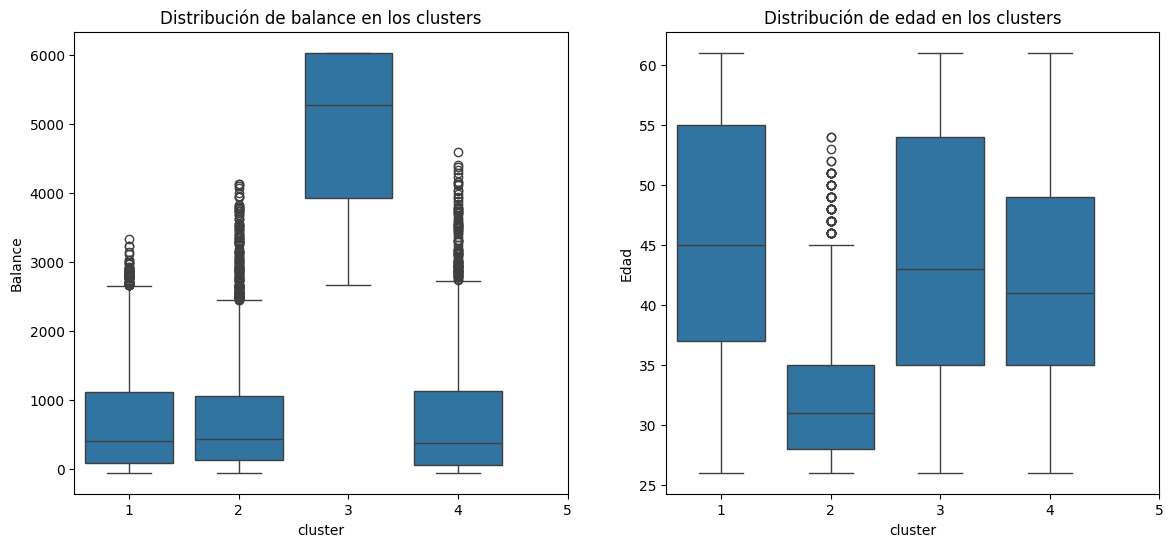

In [30]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
sns.boxplot(x='cluster', y='saldo_original', data=X_train_nuevo)
plt.title('Distribución de balance en los clusters')
plt.xlabel("cluster")
plt.ylabel("Balance")
plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])

plt.subplot(1, 2, 2)
sns.boxplot(x='cluster', y='edad_original', data=X_train_nuevo)
plt.title('Distribución de edad en los clusters')
plt.xlabel("cluster")
plt.ylabel("Edad")
plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
plt.show()

C:\Users\menes\AppData\Local\Temp\ipykernel_6592\955754006.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=X_train_nuevo, palette="viridis")


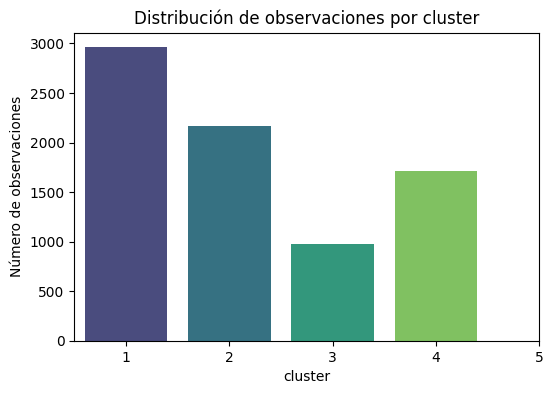

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Countplot de cada segmento
plt.figure(figsize=(6, 4))
sns.countplot(x='cluster', data=X_train_nuevo, palette="viridis")
plt.title("Distribución de observaciones por cluster")
plt.xlabel("cluster")
plt.ylabel("Número de observaciones")
plt.xticks([0, 1, 2, 3, 4], ['1', '2', '3', '4', '5'])
plt.show()


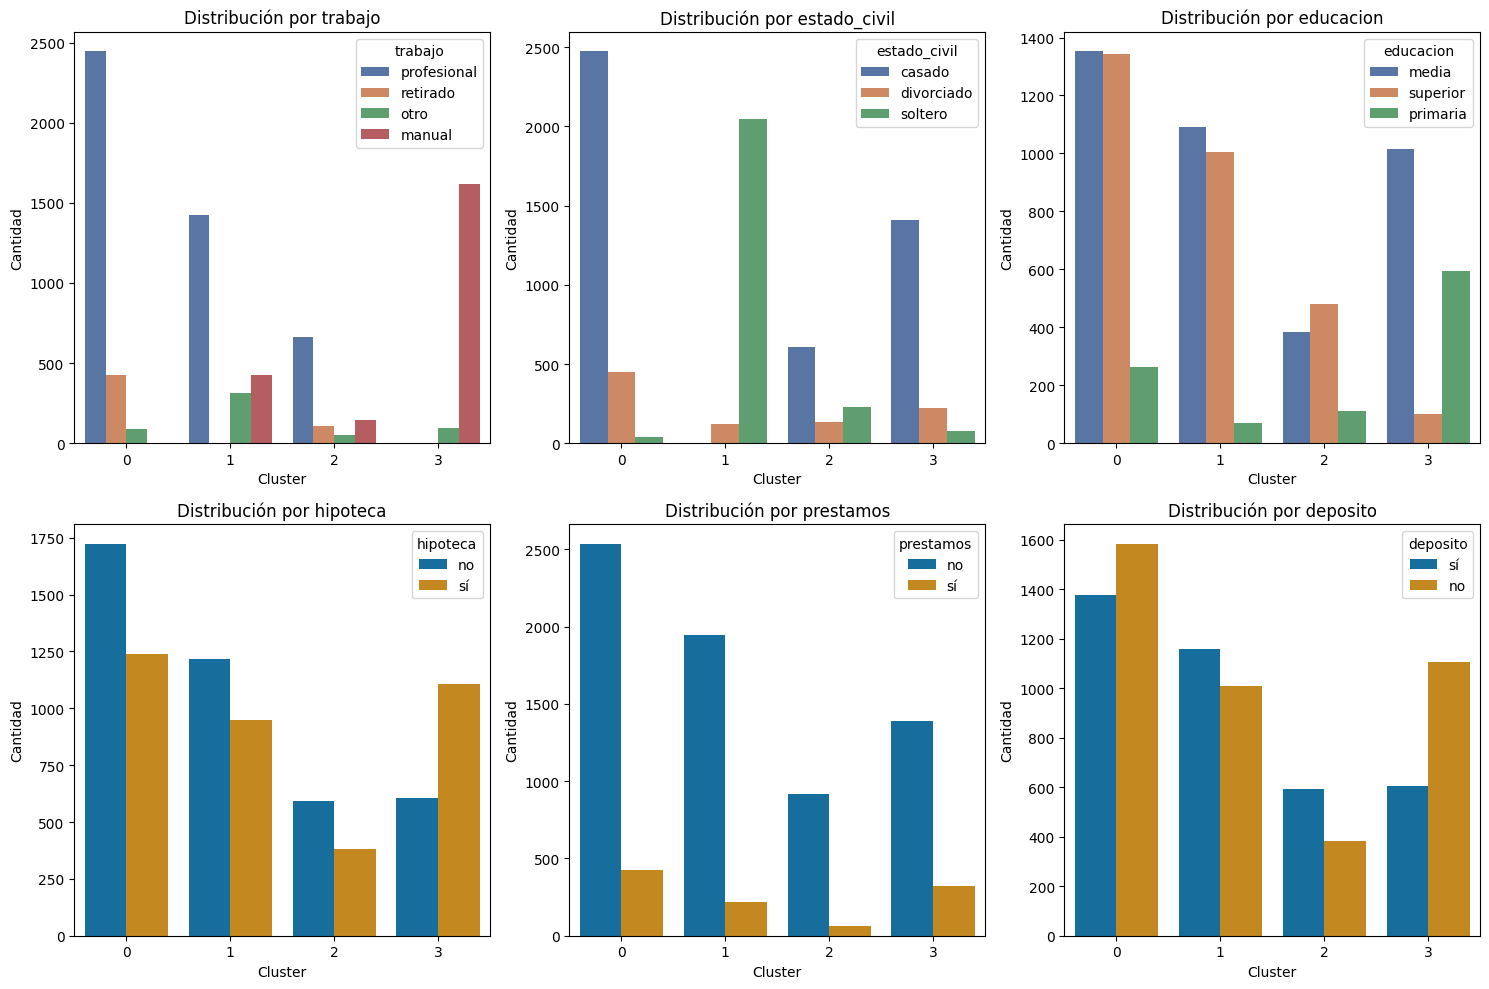

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_vars = ['trabajo','estado_civil', 'educacion']
contract_vars = ['hipoteca','prestamos', 'deposito']

# Lista de listas para agrupar las variables
all_vars = [categorical_vars, contract_vars]

# Número de filas y columnas deseadas
nrows, ncols = 2, 3

# Crear la figura
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))  

# Iterar sobre los grupos de variables y crear los subplots
for row_idx, var_group in enumerate(all_vars):
    for col_idx, var in enumerate(var_group):
        ax = axes[row_idx, col_idx]
        sns.countplot(x='cluster', hue=var, data=X_train_nuevo, ax=ax, palette='deep' if row_idx == 0 else 'colorblind')
        ax.set_title(f'Distribución por {var}')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Cantidad')

# Ajustar el espaciado entre subplots
plt.tight_layout()
plt.show()

# Interpretación de la aplicación del Algoritmo

La distribución de la agrupación de los clusters muestra los siguientes resultados:

`Cluster 1`: 
- Elementos: 2900
- Rango de Edad: 35-55 años con una media de 45 años.
- Nivel de Ingresos: Bajos con una ligera tendencia a Medios.
- Estado Civil: Mayoría de Casados(2500)
- Tipo de Trabajo: Mayoría de Profesionales(2400) y presencia de Jubilados(400)
- Nivel de Estudios: Proporciones equilibradas de Nivel Medio(1300) y Superior(1300)
- Hipoteca: Hay una cantidad de No(1700) superior a `Sí`(1200)
- Préstamo: La cantidad de clientes sin préstamos es superior `No`:(2500) y `Sí`(400)
- Deposito Contratado: Hay tantos clientes que `No` han contratado (1600) que `Sí`(1400)
- Perfil: Profesionales Estables, propensos a ahorrar y mayoritariamente casados.

- ` Productos Financieros Recomendados Línea de Productos Access Silver: `

    -	Cuentas de ahorro con bonificaciones por saldos altos.
    -	Depósitos a plazo fijo con intereses atractivos.
    -	Planes de pensiones individuales para complementar ingresos futuros.
    -	Seguros de vida o de protección familiar.
    -   Productos bancarios vinculados a la vivienda (hipotecas a tipo fijo, seguros de hogar)


`Cluster 2`: 
- Elementos: 2100 
- Rango de Edad entre 25-35 con una media de 30 años.
- Estado Civil: Mayoría Solteros (1900)
- Nivel de Ingresos: Bajos.
- Tipo de Trabajo: Mayoría de trabajo profesional(1400), seguido de trabajo manual(400) y Otros(300)
- Nivel de Estudios: Proporciones equilibradas de Nivel Medio(1050) y Superior(1000)
- Hipoteca: Mayor cantidad `No`(1200) que `Sí`(900)
- Préstamos: Mayoría de `No`(1900) que `Sí`(200)
- Deposito contratado: Cantidades equilibradas de `Sí`(1100) y `No`(1000)
- Perfil: Jóvenes profesionales solteros o recién casados e inclinados a contratar depositos.

-   `Productos Financieros Recomendados Línea de Productos Joven Flex:`

    - Cuentas de ahorro con beneficios para jóvenes (ejemplo: sin comisiones).
    - Depósitos a corto plazo con flexibilidad para retiro temprano.
    - Préstamos personales de bajo monto con tasas competitivas.
    - Educación financiera y productos de inversión iniciales.
    - Tarjetas de crédito con beneficios para jóvenes.
    - Productos Bancarios Digitales


`Cluster 3`:
- Elementos: 900
- Rango de Edad: entre 35 y 55, con una media de 44 años.
- Estado Civil: Mayoría Casados(600), solteros(250) y mínima presencia de divorciados (50)
- Nivel de Ingresos: Altos.
- Tipo de Trabajo: Mayoría de Profesionales(700), Manual(100), Jubilados(100) y Otros(100).
- Nivel de Estudios: Proporción equilibrada de Nivel Superior(500), Media(300) y Primaria(100)
- Hipoteca: Clientes con Hipoteca`Sí`(300) y `No`(600)
- Préstamos: Sin préstamos (850) y con préstamos(50)
- Deposito contratado: `No`(500) y `Sí`(300)
- Perfil: Profesionales con altos Ingresos, Educación y con una inclinación a no contratar productos bancarios masivos.

-   `Productos Financieros Recomendados Línea de Productos Total Platinum:`

    - Fondos de inversión diversificados (acciones, bonos).
    - Cuentas premium con servicios exclusivos (gestores personalizados).
    - Seguros de vida y salud de alta gama
    - Planes de inversión a largo plazo o jubilación privada.
    - Productos bancarios sostenibles o de impacto social.


`Cluster 4`:
- Elementos: 1600
- Rango de Edad: 36-48 con una media de 40 años
- Estado Civil: Mayoría de casados(1400), Divorciados(150) y Solteros(50)
- Nivel de Ingresos: Mayoría de Bajos con algunos de ingresos medios.
- Tipo de Trabajo: Mayoría de trabajos manuales (obreros, servicios y domésticos) 1550 
- Nivel de Estudios: Media(1000) y Primaria(600)
- Hipoteca: Clientes con Hipoteca`Sí`(1100) y `No`(500)
- Préstamos: Sin préstamos (1400) y con préstamos(200)
- Deposito contratado: `No`(1100) y `Sí`(500)
- Perfil: Trabajadores manuales, con ingresos bajos y obligaciones financieras.

-   `Productos Financieros Recomendados Linea de Productos Access Starter:`

    - Cuentas de ahorro sencillas con incentivos para clientes leales, tarjetas de débito.
    - Microcréditos para necesidades específicas (educación, salud, mejoras de vivienda).
    - Reestructuración de deuda (hipotecas y préstamos).
    - Planes de ahorro para metas específicas (ejemplo: educación de hijos).


Realizo la aplicación del Coeficiente de Silueta y el Índice de Calinski-Harabasz para evaluar la aplicación del algoritmo

In [33]:

silhouette_avg = silhouette_score(X_train, X_train['cluster'])
print("Coeficiente de silueta:", silhouette_avg)

Coeficiente de silueta: 0.355394996008274


In [34]:
calinski_harabasz_score = calinski_harabasz_score(X_train, X_train['cluster'])
print("Índice de Calinski-Harabasz:", calinski_harabasz_score)

Índice de Calinski-Harabasz: 3707.911919004985


In [35]:
X_train['cluster'].value_counts()

cluster
0    2960
1    2167
3    1711
2     975
Name: count, dtype: int64

El `Coeficiente de Silueta` indica una separación moderada entre los clusters, están razonablemente bien definidos; aunque los clusters son distinguibles, hay cierta superposición entre ellos. Esto podría indicar que algunos clientes en un cluster podrían ser similares a los de otro.

En el caso del `Índice de Calinski-Harabasz`, aunque no existe un umbral absoluto para este índice, este valor parece indicar que la partición obtenida es razonable en términos de separación y cohesión interna.

`Conclusión:`

La aplicación de este algoritmo de clustering sugiere una segmentación útil para personalizar la oferta de productos. Aunque los índices de calidad indican áreas de mejora (como la superposición de clusters), los perfiles identificados permiten diseñar estrategias enfocadas en las necesidades y comportamiento de cada grupo.

Los clusters parecen estar razonablemente bien definidos, aunque se podría explorar el uso de diferentes características o técnicas de preprocesamiento para mejorar la definición de los clusters, además de considerar otros algoritmos de clustering para complementar este.

Guardo el modelo y el escalador

In [36]:
import pickle

# guardo el modelo
with open('kmeans.pkl', 'wb') as model_file:
    pickle.dump(kmeans, model_file)

# guardo el escalador
with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [39]:
import pandas as pd

# Nueva entrada
nueva_entrada = {
    "edad": [20],
    "educacion": [2],  # 
    "saldo": [500],
    "hipoteca": [0],   # Sí
    "prestamos": [0],
    "deposito": [0],  # si
    "trabajo_encoded": [3],
    "estado_civil_encoded": [1]
}

# Convertir a DataFrame
nuevo_dato = pd.DataFrame(nueva_entrada)

# Escalar las variables numéricas
scale_variable = ['edad', 'saldo']
nuevo_dato[scale_variable] = scaler.transform(nuevo_dato[scale_variable])

# Predecir el cluster


perfil_map = {
    0: "1: Línea de Productos Access Silver ",
    1: "2: Línea de Productos Joven Flex",
    2: "3: Línea de Productos Total Platinum",
    3: "4: Linea de Productos Access Starter ",
}

cluster_predicho = kmeans.predict(nuevo_dato)

# Accediendo al valor del diccionario usando la predicción como clave
perfil = perfil_map.get(cluster_predicho.item(), "Perfil no encontrado")

print(f'El cliente pertenece al perfil: {perfil}')



El cliente pertenece al perfil: 2: Línea de Productos Joven Flex


In [38]:
with open('kmeans.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

loaded_model

KMeans(n_clusters=4, n_init=10, random_state=42)